# Analyse N synthesis 

created 26-09-2023

In [1]:
%matplotlib notebook

import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import glob
from importlib import reload
import pynkowski as mf   # For Minkowski Functionals

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
import scatcovjax.plotting as plot

plot.notebook_plot_format()

# Parameters

In [2]:
reality = True
sampling = 'mw'
multiresolution = True
L = 512
N = 3
epochs = 1000
J_min = 2

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')

J=8 J_max=9


# Make filters

<IPython.core.display.Javascript object>


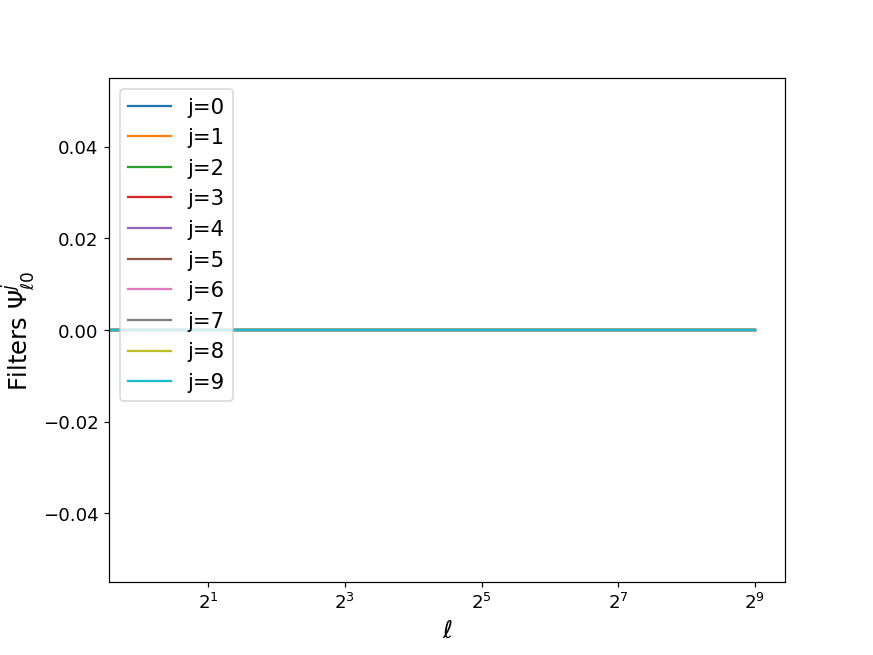

(<Figure size 800x600 with 1 Axes>,
 <Axes: xlabel='$\\ell$', ylabel='Filters $\\Psi^j_{\\ell 0}$'>)

In [3]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)

# Load the data

In [6]:
# List of job with these parameters
#job = 8137
job_list = glob.glob(f'/travail/lmousset/scatJAX_tests_sept2023/*L{L}_N{N}_Jmin{J_min}_epochs{epochs}*')

njob = len(job_list)
print(njob, job_list)


6 ['/travail/lmousset/scatJAX_tests_sept2023/Job8325_L512_N3_Jmin2_epochs1000', '/travail/lmousset/scatJAX_tests_sept2023/Job8337_L512_N3_Jmin2_epochs1000', '/travail/lmousset/scatJAX_tests_sept2023/Job8485_L512_N3_Jmin2_epochs1000_nreals3', '/travail/lmousset/scatJAX_tests_sept2023/Job8333_L512_N3_Jmin2_epochs1000', '/travail/lmousset/scatJAX_tests_sept2023/Job8332_L512_N3_Jmin2_epochs1000', '/travail/lmousset/scatJAX_tests_sept2023/Job8486_L512_N3_Jmin2_epochs1000_nreals3']


In [7]:
allflm_start, allflm_end = [], []
allloss_history = []
allcoeffs_start, allcoeffs_end= [], []
for j in range(njob):
    output_dir = job_list[j]
    print(f'\n job {j}', output_dir)
    
    nreals = int(output_dir[-1])
    if nreals == 0: ### Job with a single real
        nreals = 1
    print('Number of realisations:', nreals)
    for r in range(nreals):

        if nreals == 1:
            # flm
            flm_target = np.load(output_dir + '/flm_target.npy')
            allflm_start.append(np.load(output_dir + '/flm_start.npy'))
            allflm_end.append(np.load(output_dir + '/flm_end.npy'))
            print(flm_target.shape)

            # Loss
            allloss_history.append(np.load(output_dir + '/loss.npy'))

            # Coeffs
            coeffs_target = np.load(output_dir + '/coeffs_target.npy', allow_pickle=True)
            allcoeffs_start.append(np.load(output_dir + '/coeffs_start.npy', allow_pickle=True))
            allcoeffs_end.append(np.load(output_dir + '/coeffs_end.npy', allow_pickle=True))
        else:
             # flm
            flm_target = np.load(output_dir + f'/flm_target.npy')
            allflm_start.append(np.load(output_dir + f'/flm_start_{r}.npy'))
            allflm_end.append(np.load(output_dir + f'/flm_end_{r}.npy'))
            print(flm_target.shape)

            # Loss
            allloss_history.append(np.load(output_dir + f'/loss_{r}.npy'))

            # Coeffs
            coeffs_target = np.load(output_dir + f'/coeffs_target.npy', allow_pickle=True)
            allcoeffs_start.append(np.load(output_dir + f'/coeffs_start_{r}.npy', allow_pickle=True))
            allcoeffs_end.append(np.load(output_dir + f'/coeffs_end_{r}.npy', allow_pickle=True))
            
            


 job 0 /travail/lmousset/scatJAX_tests_sept2023/Job8325_L512_N3_Jmin2_epochs1000
Number of realisations: 1
(512, 512)

 job 1 /travail/lmousset/scatJAX_tests_sept2023/Job8337_L512_N3_Jmin2_epochs1000
Number of realisations: 1
(512, 512)

 job 2 /travail/lmousset/scatJAX_tests_sept2023/Job8485_L512_N3_Jmin2_epochs1000_nreals3
Number of realisations: 3
(512, 512)
(512, 512)
(512, 512)

 job 3 /travail/lmousset/scatJAX_tests_sept2023/Job8333_L512_N3_Jmin2_epochs1000
Number of realisations: 1
(512, 512)

 job 4 /travail/lmousset/scatJAX_tests_sept2023/Job8332_L512_N3_Jmin2_epochs1000
Number of realisations: 1
(512, 512)

 job 5 /travail/lmousset/scatJAX_tests_sept2023/Job8486_L512_N3_Jmin2_epochs1000_nreals3
Number of realisations: 3
(512, 512)
(512, 512)
(512, 512)


In [8]:
nreals = len(allflm_end)
print(nreals)

if reality:  # Get the full flm
    flm_target = sphlib.make_flm_full(flm_target, L)
    for r in range(nreals):
        allflm_start[r] = sphlib.make_flm_full(allflm_start[r] , L)
        allflm_end[r] = sphlib.make_flm_full(allflm_end[r], L)

10


In [9]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: 2**J_min + 1, :].set(0. + 0.j)

<IPython.core.display.Javascript object>


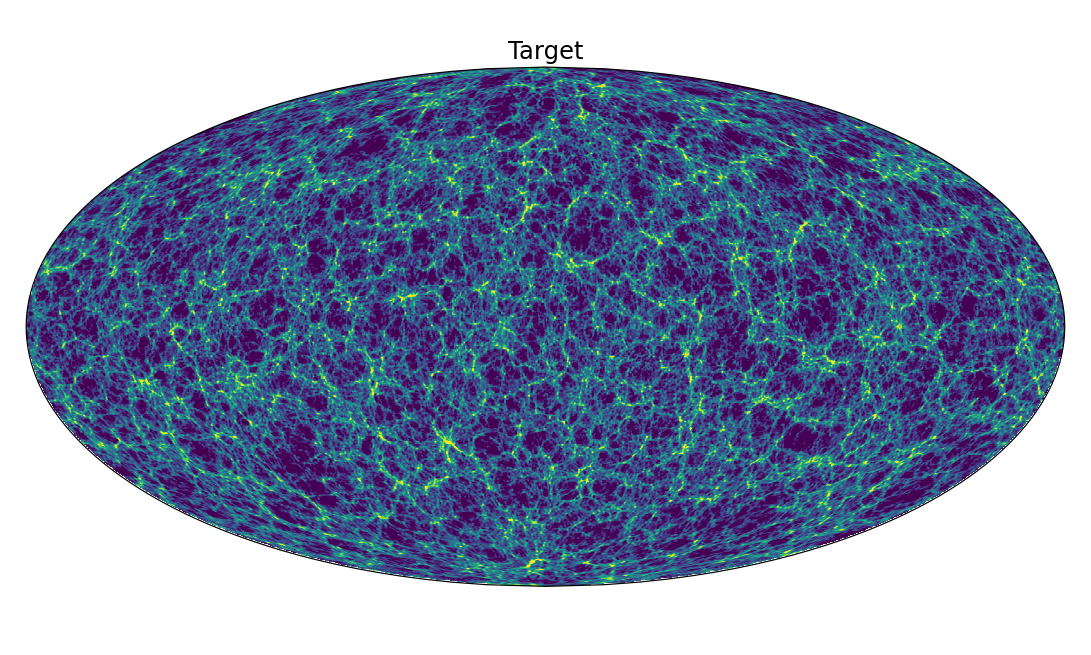

In [10]:
# Make the MW maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
mn, mx = -1, 3
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, figsize=(10, 6), title='Target')



<IPython.core.display.Javascript object>


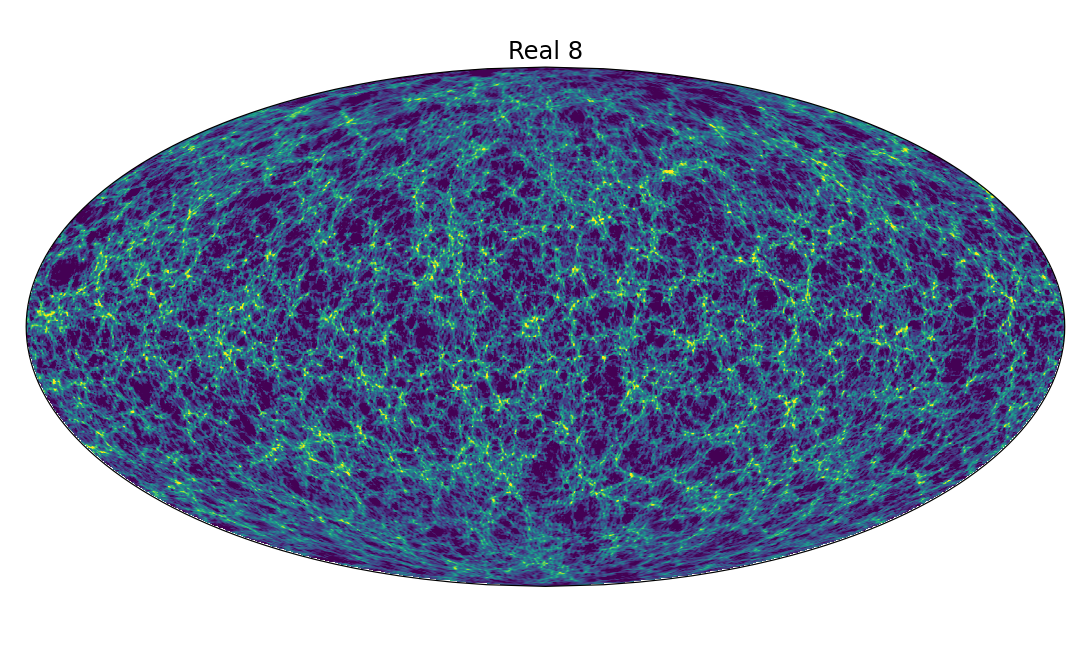

In [11]:
r = 8
f_start = s2fft.inverse_jax(allflm_start[r], L, reality=reality)
f_end = s2fft.inverse_jax(allflm_end[r], L, reality=reality)
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, figsize=(10, 6), title=f'Real {r}')

# Plot the loss

<IPython.core.display.Javascript object>


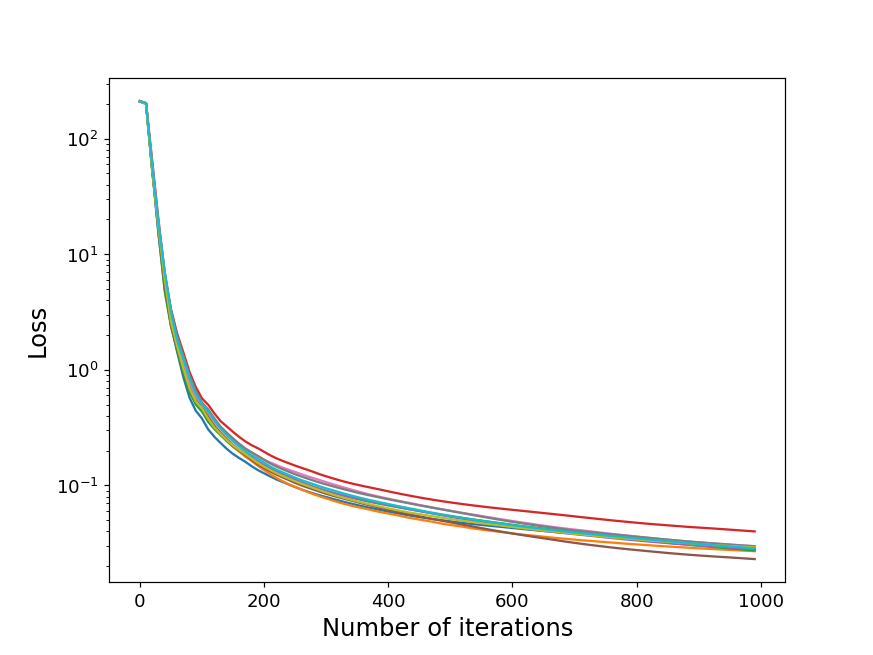

Text(0.5, 0, 'Number of iterations')

In [12]:
nit1 = 1000
step = 10

plt.figure(figsize=(8, 6))
for r in range(nreals):
    plt.plot(np.arange(0, nit1, step), allloss_history[r][:int(nit1/step)], label='All coeffs')
#plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit1/step):], 'ro--', label='All coeffs')
#plt.plot(loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

# Power spectrum

<IPython.core.display.Javascript object>


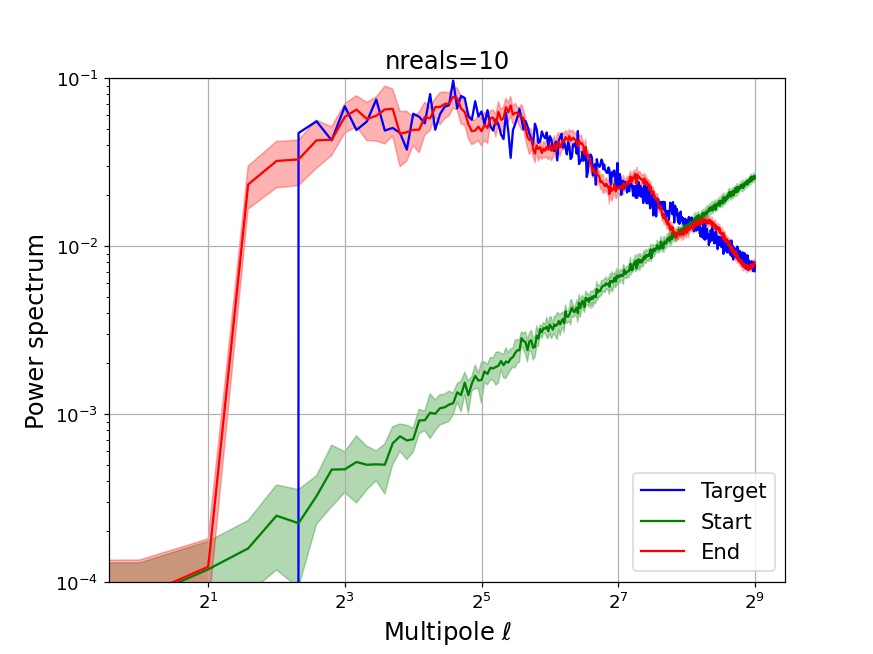

In [13]:
xx = np.arange(L)
ps_target = sphlib.compute_ps(flm_target)

allps_start, allps_end = [], []
for r in range(nreals):
    allps_start.append(sphlib.compute_ps(allflm_start[r]))
    allps_end.append(sphlib.compute_ps(allflm_end[r]))

allps_start = np.array(allps_start)
allps_end = np.array(allps_end)

std_ps_start = np.std(allps_start, axis=0)
std_ps_end = np.std(allps_end, axis=0)

mean_ps_start = np.mean(allps_start, axis=0)
mean_ps_end = np.mean(allps_end, axis=0)

plt.figure(figsize=(8, 6))
plt.title(f'{nreals=}')
plt.plot(ps_target, 'b', label="Target")

plt.plot(mean_ps_start, 'g', label="Start")
plt.fill_between(xx, mean_ps_start - std_ps_start, mean_ps_start + std_ps_start, color='g', alpha=0.3)

plt.plot(mean_ps_end, 'r', label="End")
plt.fill_between(xx, mean_ps_end - std_ps_end, mean_ps_end + std_ps_end, color='r', alpha=0.3)

plt.yscale("log")
plt.xscale("log", base=2)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 256)
plt.ylim(1e-4, 1e-1)
plt.legend()

# Scat cov coeffs

<IPython.core.display.Javascript object>


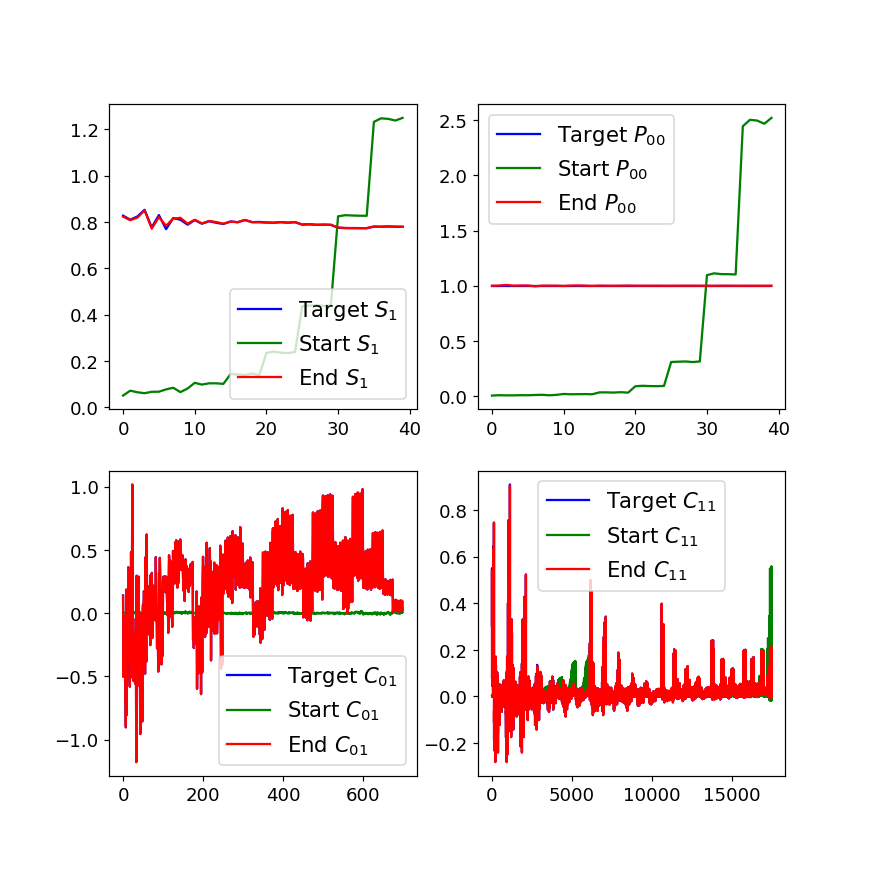

In [49]:
tmean, tvar, tS1, tP00, tC01, tC11 = coeffs_target

# Do the plot for a single real
r = 2
smean, svar, sS1, sP00, sC01, sC11 = allcoeffs_start[r]
emean, evar, eS1, eP00, eC01, eC11 = allcoeffs_end[r]

plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')
plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')
plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')


# Skewness and kurtosis

In [14]:
def skewness(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**3)

def kurtosis(X):
    mu = np.mean(X)
    std = np.std(X)
    return np.mean(((X-mu) / std)**4)

In [15]:
### On the MW maps
# Skewness and kurtosis
tskew = skewness(f_target)
tkurt = kurtosis(f_target)

all_eskew = np.zeros(nreals)
all_ekurt = np.zeros(nreals)
for r in range(nreals):
    f_start = s2fft.inverse_jax(allflm_start[r], L, reality=reality, sampling='mw')
    f_end = s2fft.inverse_jax(allflm_end[r], L, reality=reality, sampling='mw')

    f_start = np.array(np.real(f_start))
    f_end = np.array(np.real(f_end))
    
    # Skewness and kurtosis
    all_eskew[r] = skewness(f_end)
    all_ekurt[r] = kurtosis(f_end)

mean_skew = np.mean(all_eskew)
mean_kurt = np.mean(all_ekurt)

std_skew = np.std(all_eskew)
std_kurt = np.std(all_ekurt)

print(tskew, mean_skew, '+-', std_skew)
print(tkurt, mean_kurt, '+-', std_kurt)

0.6611806192936251 0.6156150243074958 +- 0.009826600468960084
3.7699726214233324 3.726382537358943 +- 0.032347616054627375


In [13]:
### Convert the map in a Healpix map
f_target_hpx = s2fft.inverse_jax(flm_target, L, nside=int(L/2), reality=reality, sampling='healpix')
# Take the real part and convert to a np.array
f_target_hpx = np.array(np.real(f_target_hpx))

# Skewness and kurtosis
tskew = skewness(f_target_hpx)
tkurt = kurtosis(f_target_hpx)

all_eskew = np.zeros(nreals)
all_ekurt = np.zeros(nreals)
for r in range(nreals):
    f_start_hpx = s2fft.inverse_jax(allflm_start[r], L, nside=int(L/2), reality=reality, sampling='healpix')
    f_end_hpx = s2fft.inverse_jax(allflm_end[r], L, nside=int(L/2), reality=reality, sampling='healpix')

    f_start_hpx = np.array(np.real(f_start_hpx))
    f_end_hpx = np.array(np.real(f_end_hpx))
    
    # Skewness and kurtosis
    all_eskew[r] = skewness(f_end_hpx)
    all_ekurt[r] = kurtosis(f_end_hpx)

mean_skew = np.mean(all_eskew)
mean_kurt = np.mean(all_ekurt)

std_skew = np.std(all_eskew)
std_kurt = np.std(all_ekurt)

print(tskew, mean_skew, '+-', std_skew)
print(tkurt, mean_kurt, '+-', std_kurt)

0.6777783886771829 0.5700774543997745 +- 0.0029602045622406027
3.8129371168469923 3.611277478110602 +- 0.013867345839093957


# Histogram

In [16]:
# Do it for one real
r = 4
f_start_hpx = s2fft.inverse_jax(allflm_start[r], L, nside=int(L/2), reality=reality, sampling='healpix')
f_end_hpx = s2fft.inverse_jax(allflm_end[r], L, nside=int(L/2), reality=reality, sampling='healpix')

f_start_hpx = np.array(np.real(f_start_hpx))
f_end_hpx = np.array(np.real(f_end_hpx))

<IPython.core.display.Javascript object>


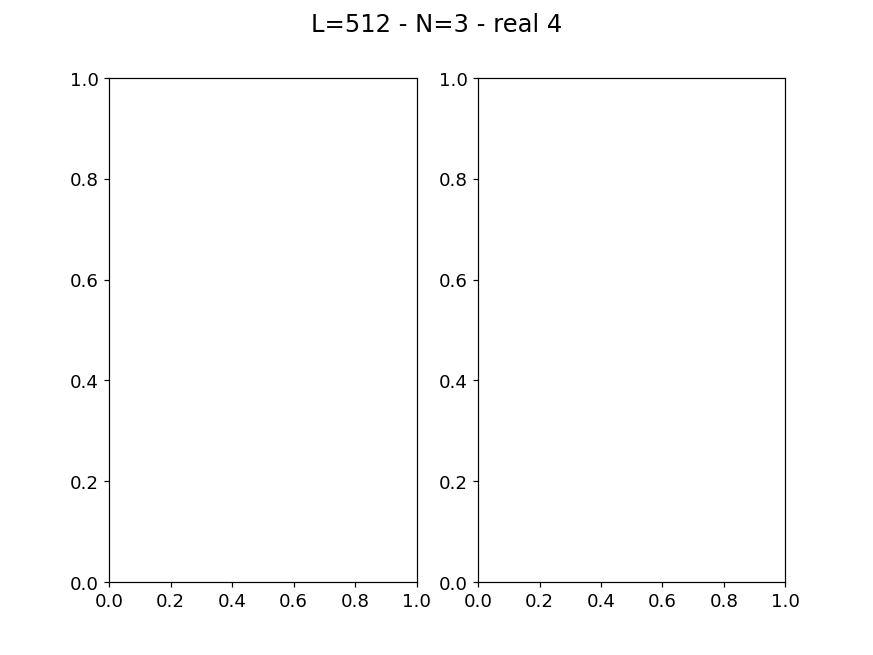

NameError: name 'f_target_hpx' is not defined

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle(f'{L=} - {N=} - real {r}')

ax0.hist(f_target_hpx, bins=30, range=(f_target_hpx.min(), f_target_hpx.max()),
         density=False, color='r', alpha=0.2, label=f'Target')
ax0.hist(f_end_hpx, bins=30, range=(f_target_hpx.min(), f_target_hpx.max()), 
         density=False, color='b', alpha=0.2, label=f'End')
ax0.set_title('Healpix PDF')
ax0.set_yscale("log")
ax0.set_ylim(10, 2e5)
ax0.legend()

ax1.hist(np.ravel(f_target), bins=30, range=(f_target.min(), f_target.max()), 
         density=False, color='r', alpha=0.2, label='Target')
ax1.hist(np.ravel(f_end), bins=30, range=(f_target.min(), f_target.max()), 
         density=False, color='b', alpha=0.2, label='End')
ax1.set_title('MW PDF')
ax1.set_yscale("log")
ax1.set_ylim(10, 2e5)
ax1.legend()

# Minkowski

In [56]:
def make_minkowski(us, map_hpx):

    data = mf.Healpix(map_hpx, normalise=True, mask=None)     # Default parameters
    v0 = mf.V0(data, us)
    v1 = mf.V1(data, us)
    v2 = mf.V2(data, us)
    
    return v0, v1, v2

In [64]:
us = np.arange(-5., 7.01, 0.1)

v0_target, v1_target, v2_target = make_minkowski(us, f_target_hpx)

all_v0_start, all_v1_start, all_v2_start  = np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size))
all_v0_end, all_v1_end, all_v2_end  = np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size)), np.zeros((nreals, v0_target.size))
for r in range(nreals):
    f_start_hpx = s2fft.inverse_jax(allflm_start[r], L, nside=int(L/2), reality=reality, sampling='healpix')
    f_end_hpx = s2fft.inverse_jax(allflm_end[r], L, nside=int(L/2), reality=reality, sampling='healpix')

    f_start_hpx = np.array(np.real(f_start_hpx))
    f_end_hpx = np.array(np.real(f_end_hpx))
    
    all_v0_start[r], all_v1_start[r], all_v2_start[r] = make_minkowski(us, f_start_hpx)
    all_v0_end[r], all_v1_end[r], all_v2_end[r] = make_minkowski(us, f_end_hpx)

### Compute mean and std over realisations
mean_v0_start = np.mean(all_v0_start, axis=0)
mean_v1_start = np.mean(all_v1_start, axis=0)
mean_v2_start = np.mean(all_v2_start, axis=0)

mean_v0_end = np.mean(all_v0_end, axis=0)
mean_v1_end = np.mean(all_v1_end, axis=0)
mean_v2_end = np.mean(all_v2_end, axis=0)

std_v0_start = np.std(all_v0_start, axis=0)
std_v1_start = np.std(all_v1_start, axis=0)
std_v2_start = np.std(all_v2_start, axis=0)

std_v0_end = np.std(all_v0_end, axis=0)
std_v1_end = np.std(all_v1_end, axis=0)
std_v2_end = np.std(all_v2_end, axis=0)

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


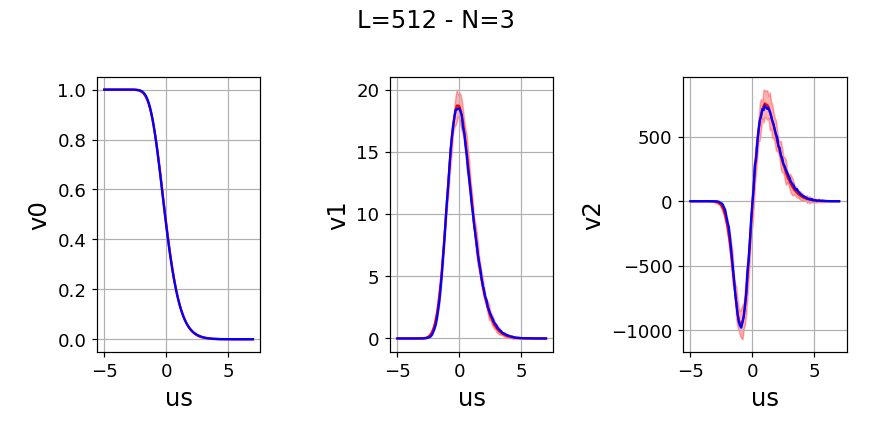

In [76]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))
fig.suptitle(f'{L=} - {N=}')

#ax0.plot(us, mean_v0_start, color='g', label='Start')
#ax0.fill_between(us, mean_v0_start - std_v0_start, mean_v0_start + std_v0_start, color='g', alpha=0.3)
ax0.plot(us, mean_v0_end, color='r', label='End')
ax0.fill_between(us, mean_v0_end - 10*std_v0_end, mean_v0_end + 10*std_v0_end, color='r', alpha=0.3)
ax0.plot(us, v0_target, color='b', label='Target')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()
#ax0.legend()

#ax1.plot(us, mean_v1_start, color='g', label='Start')
#ax1.fill_between(us, mean_v1_start - std_v1_start, mean_v1_start + std_v1_start, color='g', alpha=0.3)
ax1.plot(us, mean_v1_end, color='r', label='End')
ax1.fill_between(us, mean_v1_end - 10*std_v1_end, mean_v1_end + 10*std_v1_end, color='r', alpha=0.3)
ax1.plot(us, v1_target, color='b', label='Target')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()
#ax1.legend()

#ax2.plot(us, mean_v2_start, color='g', label='Start')
#ax2.fill_between(us, mean_v2_start - std_v2_start, mean_v2_start + std_v2_start, color='g', alpha=0.3)
ax2.plot(us, mean_v2_end, color='r', label='End')
ax2.fill_between(us, mean_v2_end - 10*std_v2_end, mean_v2_end + 10*std_v2_end, color='r', alpha=0.3)
ax2.plot(us, v2_target, color='b', label='Target')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()
#ax2.legend()

fig.tight_layout()

<IPython.core.display.Javascript object>


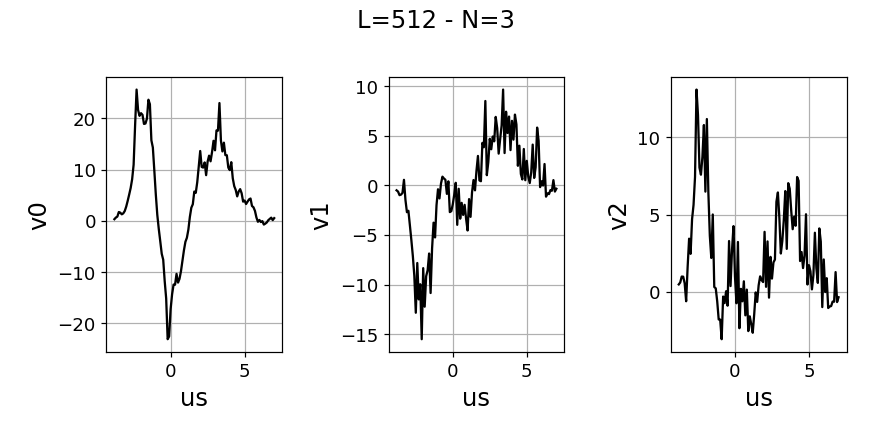

In [78]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(8, 4))
fig.suptitle(f'{L=} - {N=}')

ax0.plot(us, (v0_target - mean_v0_end)/std_v0_end, color='k')
ax0.set_xlabel('us')
ax0.set_ylabel('v0')
ax0.grid()

ax1.plot(us, (v1_target - mean_v1_end)/std_v1_end, color='k')
ax1.set_xlabel('us')
ax1.set_ylabel('v1')
ax1.grid()

ax2.plot(us, (v2_target - mean_v2_end)/std_v2_end, color='k')
ax2.set_xlabel('us')
ax2.set_ylabel('v2')
ax2.grid()

fig.tight_layout()